In [1]:
import sys
import os
sys.path.append(sys.path[0] + "/..")

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from jupyterthemes import jtplot
import datetime
jtplot.style()

In [2]:
# directory = '../experiments/data/raw/DJA-stocks'

# dja = []
# for filename in os.listdir(directory):
#     if filename.endswith(".csv"):
#         df = pd.read_csv(directory + "/" + filename)
#         df.name = filename.split('-')[1]
#         df['name'] = df.name
#         df.columns = df.columns.str.replace('\d+', '').str.replace('.', '').str.replace(' ', '')
#         dja.append(df)
        
# df_dja = pd.concat(dja, axis=0)
# df_dja.to_csv('../experiments/data/raw/DJA-2000-2020.csv')

In [3]:
# df_dja = df_dja.drop(['volume'], axis=1)
# df_dja.to_csv('../experiments/data/interim/DJA-2000-2020-clean.csv')

In [4]:
df_dja = pd.read_csv('../experiments/data/interim/DJA-2000-2020-clean.csv')
df_dja['date'] = pd.to_datetime(df_dja['date'])
df_dja.set_index('date', inplace=True)
df_dja = df_dja.drop('Unnamed: 0', axis=1)
df_dja.head()

,open,high,low,close,name
date,,,,,
2000-05-11,101.37,104.25,99.00,102.81,AAPL
2000-05-12,106.00,110.50,104.77,107.62,AAPL
2000-05-15,108.06,108.06,100.12,101.00,AAPL
2000-05-16,104.52,109.06,102.75,105.69,AAPL
2000-05-17,103.62,103.69,100.37,101.37,AAPL


In [5]:
df_dja = df_dja[(df_dja['name'] != 'V') & (df_dja['name'] != 'DOW')]

In [6]:
from hedgepy.core import build_series, build_network_time_series
from hedgepy.utils import write_series, read_series, read_data

# dja_series = build_series(df=df_dja, ticker_col_name='name', rolling_window=90, detrend=True, coalesce=True)

In [7]:
# write_series(dja_series, file_name='DJA-2000-2020-rolling-90d-dcor-diff.json')
dja_series = read_series('DJA-2000-2020-rolling-90d-dcor.json')

In [8]:
# not sure why first df is all nans... will have to loops over dict and drop if df contains any nans
dja_series.pop(pd.Timestamp('2000-09-18 00:00:00'))

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,NKE,PFE,PG,RTX,TRV,UNH,VZ,WBA,WMT,XOM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_dja_index = pd.read_csv('../experiments/data/raw/DJA-index/DJA-2000-2020-index.csv')
df_dja_index['Date'] = pd.to_datetime(df_dja_index['Date'])
df_dja_index.set_index('Date', inplace=True)
df_dja_index.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-11,10369.269531,10575.099609,10369.269531,10545.969727,10545.969727,185720000
2000-05-12,10549.059570,10673.790039,10543.919922,10609.370117,10609.370117,137770000
2000-05-15,10606.969727,10811.549805,10605.259766,10807.780273,10807.780273,155810000
2000-05-16,10816.009766,10971.240234,10816.009766,10934.570313,10934.570313,181920000
2000-05-17,10930.639648,10930.639648,10752.610352,10769.740234,10769.740234,169570000


In [10]:
from hedgepy.centrality import global_degree_centrality, global_eigencentrality

# nx_ts_soft = build_network_time_series(dja_series, soft_threshold=True)

In [11]:
nx_ts_hard = build_network_time_series(dja_series, soft_threshold=False)

In [12]:
nx_ts_02 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.2)
nx_ts_03 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.3)
nx_ts_04 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.4)
nx_ts_05 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.5)
nx_ts_06 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.6)
nx_ts_07 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.7)
nx_ts_08 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.8)
nx_ts_09 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.9)

In [13]:
nx_ts_list = [nx_ts_02, nx_ts_03, nx_ts_04, nx_ts_05, nx_ts_06, nx_ts_07, nx_ts_08, nx_ts_09]

df_list = [global_degree_centrality(G) for G in nx_ts_list]
df_dc = pd.concat(df_list, axis=1)

In [14]:
from hedgepy.centrality import global_clustering

In [15]:
df_ec = global_eigencentrality(nx_ts_hard)
# df_ec = global_clustering(nx_ts_soft)

In [16]:
# df_ec.columns = ['global_eigencentrality']

In [17]:
col_names = [f'dcor > {i}' for i in [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]]
df_dc.columns = col_names

C:\Users\maya.benowitz\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


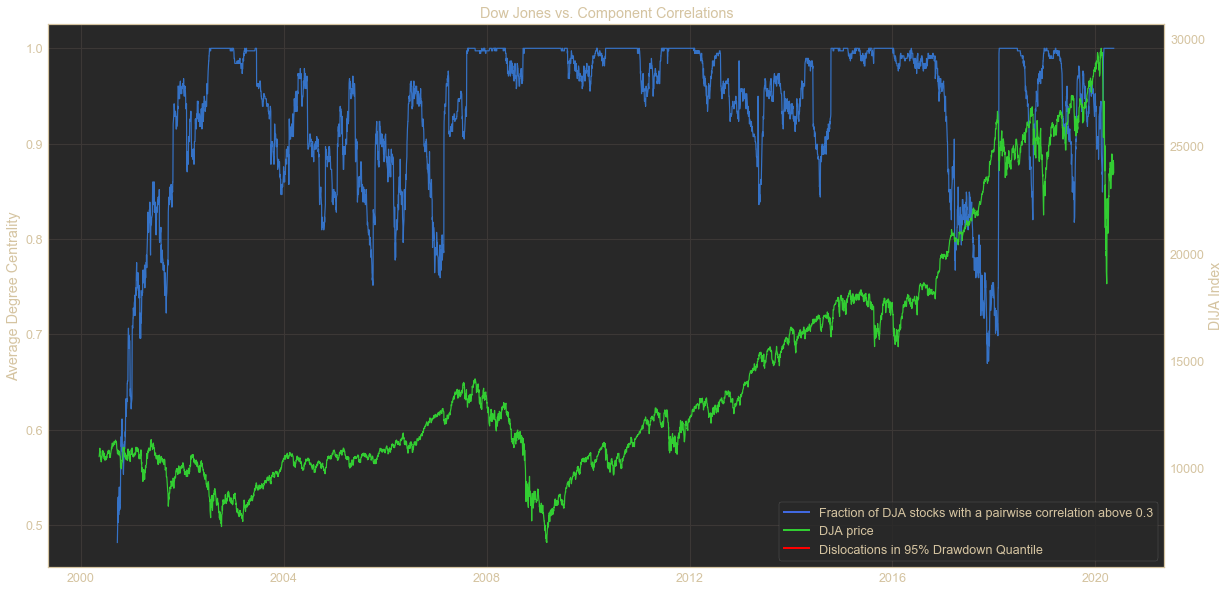

In [18]:
from matplotlib.lines import Line2D
colors = ['royalblue', 'limegreen', 'red']
lines = [ Line2D([0], [0], color=c, linewidth=2) for c in colors ]
labels = ['Fraction of DJA stocks with a pairwise correlation above 0.3', 'DJA price', 'Dislocations in 95% Drawdown Quantile']

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_dc['dcor > 0.3'])
# [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(dislocations['d_start'], dislocations['d_end'])]
ax.set_ylabel('Average Degree Centrality')
ax.set_title('Dow Jones vs. Component Correlations')
plt.legend(lines, labels)
ax2 = ax.twinx()
ax2.plot(df_dja_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
ax2.grid(False)
# plt.savefig('../experiments/resources/dja-correlation-above-03-2000-2020', bbox_inches="tight")

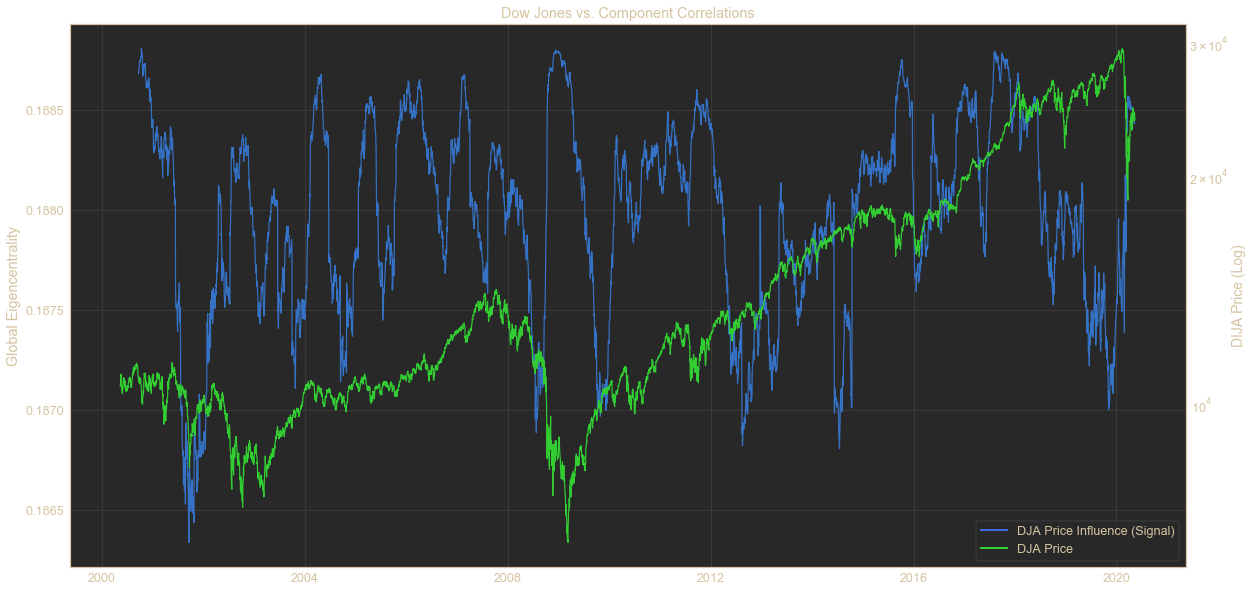

In [19]:
# explain social network analysis (eigencentrality as a measure of price power, equivalence to 'aggregated correlation')
# produces predictive signal (p-value < 0.01) with a "prediction horizion" of 87 days

from matplotlib.lines import Line2D
colors = ['royalblue', 'limegreen', 'red']
lines = [ Line2D([0], [0], color=c, linewidth=2) for c in colors ]
labels = ['DJA Price Influence (Signal)', 'DJA Price']

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ec['global_eigencentrality'])
# [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(dislocations['d_start'], dislocations['d_end'])]
ax.set_ylabel('Global Eigencentrality')
ax.set_title('Dow Jones vs. Component Correlations')
plt.legend(lines, labels)
ax2 = ax.twinx()
ax2.plot(df_dja_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Price (Log)', fontsize=14)
ax2.set_yscale('log')
ax2.grid(False)
# plt.savefig('../experiments/resources/dja-eigencent-2000-2020', bbox_inches="tight")

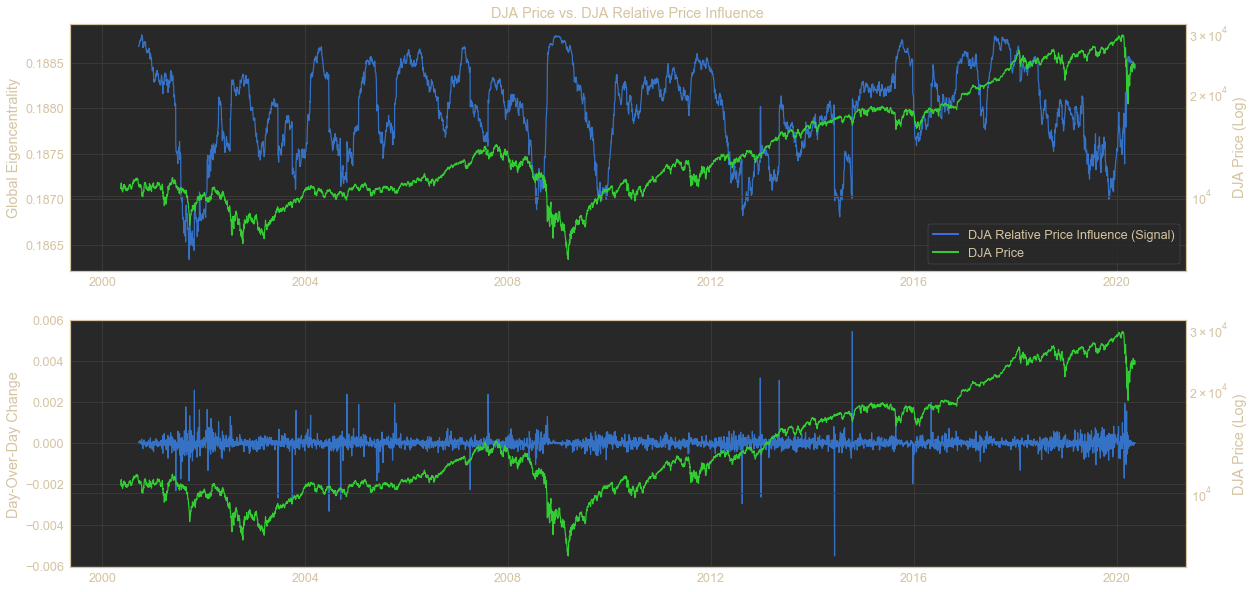

In [20]:
from matplotlib.lines import Line2D
colors = ['royalblue', 'limegreen', 'red']
lines = [ Line2D([0], [0], color=c, linewidth=2) for c in colors ]
labels = ['Change in DJA Price Influence']
labels2 = ['DJA Relative Price Influence (Signal)', 'DJA Price']
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

fig, ax = plt.subplots(figsize=(20,10))
plt.subplot(gs[0])
plt.plot(df_ec['global_eigencentrality'])
plt.title('DJA Price vs. DJA Relative Price Influence')
plt.ylabel('Global Eigencentrality')
plt.legend(lines, labels2)
ax2 = plt.twinx()
ax2.set_ylabel('DJA Price (Log)')
plt.plot(df_dja_index['Close'], color='limegreen')
ax2.set_yscale('log')

plt.subplot(gs[1])
plt.plot(df_ec['global_eigencentrality'].pct_change())
plt.ylabel('Day-Over-Day Change')
ax3 = plt.twinx()
ax3.set_ylabel('DJA Price (Log)')
plt.plot(df_dja_index['Close'], color='limegreen')
ax3.set_yscale('log')
# plt.savefig('../experiments/resources/dja-eigencent-dual-2000-2020', bbox_inches="tight")

In [21]:
df_gtest = pd.DataFrame({'DJA': df_dja_index['Close'], 'eigen': df_ec['global_eigencentrality']})
df_gtest.dropna(inplace=True)

In [22]:
df_gtest2 = pd.DataFrame({'DJA': df_dja_index['Close'], 'deg_03': df_dc['dcor > 0.3']})
df_gtest2.dropna(inplace=True)

In [23]:
from statsmodels.tsa.stattools import grangercausalitytests, coint, adfuller
gc = grangercausalitytests(df_gtest, 252, verbose=False)

In [24]:
# signal is stationary with p-value = 8.6 x 10^-5
adfuller(df_ec['global_eigencentrality'])

(-4.952199928608632,
 2.7570916806089348e-05,
 15,
 4926,
 {'1%': -3.431678199534402,
  '5%': -2.862126918629921,
  '10%': -2.56708241783182},
 -82631.86507571333)

In [25]:
aic_scores = []
for lag in range(1, 252):
    aic = gc[lag][1][0].aic
    aic_scores.append(aic)

In [26]:
aic_df = pd.DataFrame({'lags': list(range(1,252)), 'aic_score': aic_scores})

In [27]:
p_values_lr = []
p_values_ft = []
p_values_chi = []
p_values_ssrft = []
for lag in range(1, 252):
    lrtest = gc[lag][0]['lrtest'][1]
    chi2test = gc[lag][0]['ssr_chi2test'][1]
    params_ftest = gc[lag][0]['params_ftest'][1]
    ssr_ftest = gc[lag][0]['ssr_ftest'][1]
    p_values_lr.append(lrtest)
    p_values_ft.append(params_ftest)
    p_values_chi.append(chi2test)
    p_values_ssrft.append(ssr_ftest)
    
gtest_df = pd.DataFrame({'lrtest': p_values_lr, 'params_ftest': p_values_ft, 'chi2test': p_values_chi, 'ssr_ftest': p_values_ssrft})
gtest_df.head()

,lrtest,params_ftest,chi2test,ssr_ftest
0,0.365353,0.365523,0.365333,0.365523
1,0.154498,0.154790,0.154389,0.154790
2,0.232896,0.233444,0.232716,0.233444
3,0.160847,0.161504,0.160578,0.161504
4,0.031997,0.032295,0.031806,0.032295


In [28]:
gtest_aic_df = gtest_df.merge(aic_df, right_index=True, left_index=True)
gtest_aic_df.head()

,lrtest,params_ftest,chi2test,ssr_ftest,lags,aic_score
0,0.365353,0.365523,0.365333,0.365523,1,65150.676579
1,0.154498,0.154790,0.154389,0.154790,2,65012.351423
2,0.232896,0.233444,0.232716,0.233444,3,64981.387853
3,0.160847,0.161504,0.160578,0.161504,4,64956.931896
4,0.031997,0.032295,0.031806,0.032295,5,64937.221483


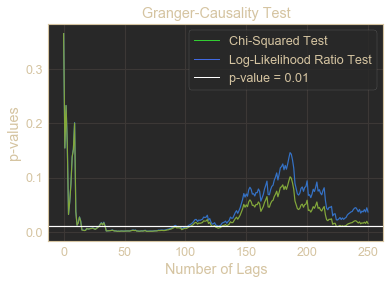

In [29]:
# theres a predicitive pocket ranging from 40-90 lag days

plt.plot(p_values_lr)
plt.plot(p_values_chi)
# plt.plot(p_values_ft)
# plt.plot(p_values_ssrft)
plt.title('Granger-Causality Test')
plt.ylabel('p-values')
plt.xlabel('Number of Lags')
plt.axhline(0.01, color='white')

colors = ['limegreen', 'royalblue', 'white']
lines = [ Line2D([0], [0], color=c, linewidth=1) for c in colors ]
labels = ['Chi-Squared Test', 'Log-Likelihood Ratio Test', 'p-value = 0.01']
plt.legend(lines, labels)

In [30]:
#ftest aic
sig_gtest = gtest_aic_df[(gtest_aic_df['params_ftest'] < 0.01)]
sig_gtest[sig_gtest['aic_score'] == sig_gtest['aic_score'].min()]

,lrtest,params_ftest,chi2test,ssr_ftest,lags,aic_score
86,0.004726,0.008437,0.003553,0.008437,87,63685.990043


In [31]:
sig_gtest = gtest_aic_df[(gtest_aic_df['ssr_ftest'] < 0.01)]
sig_gtest[sig_gtest['aic_score'] == sig_gtest['aic_score'].min()]

,lrtest,params_ftest,chi2test,ssr_ftest,lags,aic_score
86,0.004726,0.008437,0.003553,0.008437,87,63685.990043


In [32]:
#lrtest aic
sig_gtest = gtest_aic_df[(gtest_aic_df['lrtest'] < 0.01)]
sig_gtest[sig_gtest['aic_score'] == sig_gtest['aic_score'].min()]

,lrtest,params_ftest,chi2test,ssr_ftest,lags,aic_score
127,0.009848,0.024249,0.006453,0.024249,128,63192.491008


In [33]:
#chi2test aic
sig_gtest = gtest_aic_df[(gtest_aic_df['chi2test'] < 0.01)]
sig_gtest[sig_gtest['aic_score'] == sig_gtest['aic_score'].min()]

,lrtest,params_ftest,chi2test,ssr_ftest,lags,aic_score
230,0.022883,0.129378,0.009772,0.129378,231,61920.586989


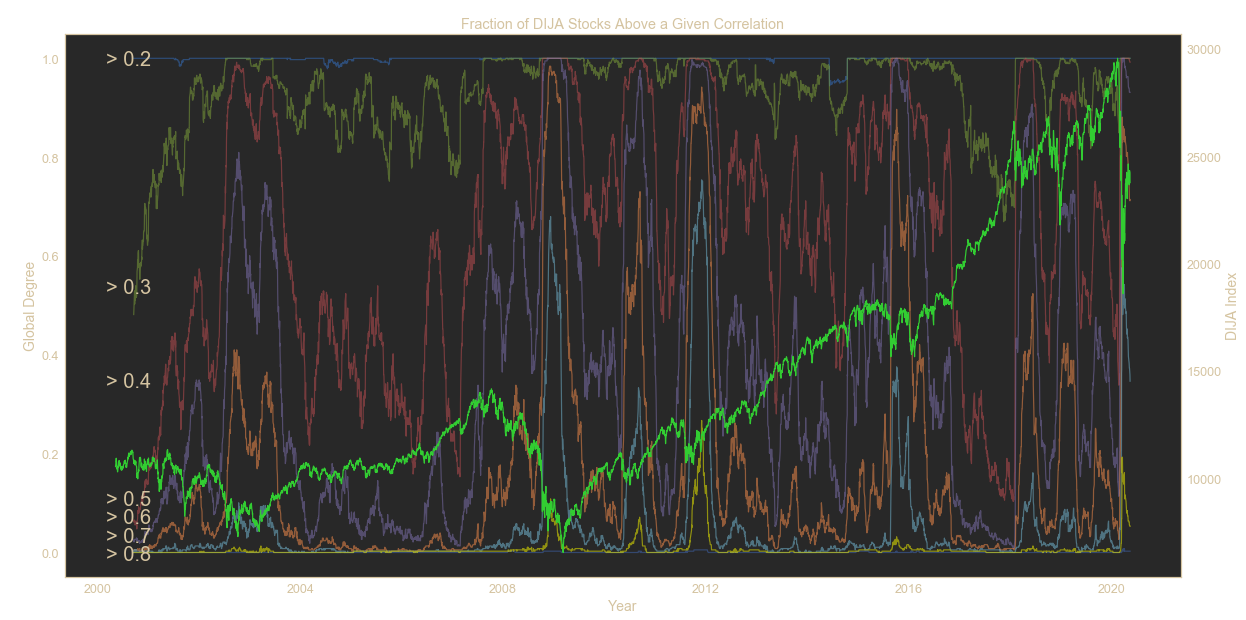

In [34]:
fig, ax = plt.subplots(figsize=(20,10))
for col in df_dc.columns:
    ax.plot(df_dc[col], alpha=0.5)
    
ax.plot(df_dc['dcor > 0.8'], alpha=0.5, color='yellow')
# [plt.axvspan(x1, x2, alpha=0.5, color='red', linestyle='dotted') for x1, x2 in zip(dislocations['d_start'], dislocations['d_end'])]

ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Global Degree", fontsize=14)
ax.set_title('Fraction of DIJA Stocks Above a Given Correlation')
ax.grid(False)
ax.annotate('> 0.2',
            xy=(0.085, .918), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.3',
            xy=(0.085, .55), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.4',
            xy=(0.085, .40), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.5',
            xy=(0.085, .21), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.6',
            xy=(0.085, .18), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.7',
            xy=(0.085, .15), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.8',
            xy=(0.085, .12), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)

ax2 = ax.twinx()
ax2.plot(df_dja_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
ax2.grid(False)
# plt.savefig('../experiments/resources/dja-correlation-gradient-2000-2020', bbox_inches="tight")

In [35]:
df_ec['pct_change'] = df_ec[['global_eigencentrality']].pct_change()
df_ec.dropna(inplace=True)

In [36]:
def optimize_OneClassSVM(X, n):
    print('searching for optimal hyperparameters...')
    nu = np.linspace(start=1e-5, stop=1e-2, num=n)
    gamma = np.linspace(start=1e-6, stop=1e-3, num=n)
    opt_diff = 1.0
    opt_nu = None
    opt_gamma = None
    for i in range(len(nu)):
        for j in range(len(gamma)):
            classifier = OneClassSVM(kernel="rbf", nu=nu[i], gamma=gamma[j])
            classifier.fit(X)
            label = classifier.predict(X)
            p = 1 - float(sum(label == 1.0)) / len(label)
            diff = math.fabs(p - nu[i])
            if diff < opt_diff:
                opt_diff = diff
                opt_nu = nu[i]
                opt_gamma = gamma[j]
    return opt_nu, opt_gamma

In [37]:
X_train = df_ec[['pct_change']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(np_scaled).dropna()

opt_nu, opt_gamma = optimize_OneClassSVM(X_train, n=20)

searching for optimal hyperparameters...


In [38]:
print(opt_nu)
print(opt_gamma)

0.007896842105263159
0.00010615789473684212


In [39]:
from sklearn.ensemble import IsolationForest
# model = OneClassSVM(nu=1/np.sqrt(len(df_ec)), kernel='rbf', gamma=1/len(df_ec))
model = IsolationForest(contamination=0.013, behaviour="new")
model.fit(X_train)
anomalies = pd.Series(model.predict(X_train), index=df_ec.index)

In [40]:
1/(np.sqrt(len(df_ec)))

0.014226319992543996

In [41]:
np.power(1/len(df_ec), 0.45)

0.02176623510079136

In [42]:
df_ec['anomalies'] = anomalies
df_ec['DJA'] = df_dja_index['Close']

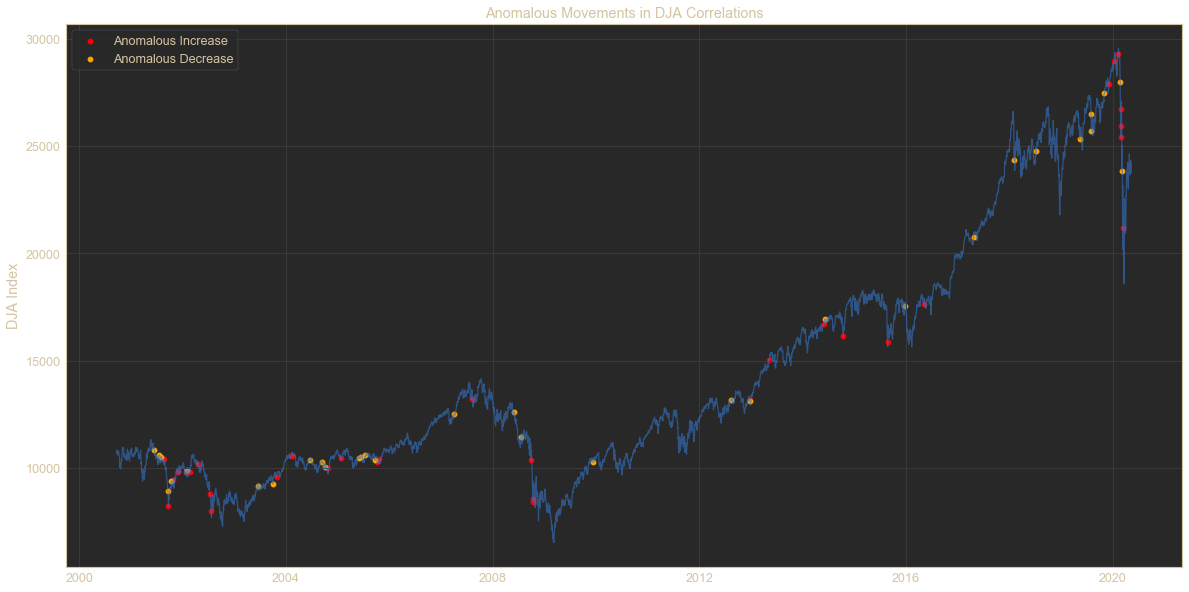

In [43]:
a = df_ec.loc[(df_ec['anomalies'] == -1)]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ec.index, df_ec['DJA'], alpha=0.6)

b = a.loc[a['pct_change'] > 0]
c = a.loc[a['pct_change'] < 0]

bsize = np.abs([(i*10000)**1.5 for i in b['pct_change'].tolist()])
csize = np.abs([(i*10000)**1.5 for i in c['pct_change'].tolist()])
ax.scatter(df_ec['DJA'][(df_ec['anomalies']==-1) & (df_ec['pct_change'] > 0)].index, df_ec['DJA'][(df_ec['anomalies']==-1) & (df_ec['pct_change'] > 0)], label='Anomalous Increase', color='red')
ax.scatter(df_ec['DJA'][(df_ec['anomalies']==-1) & (df_ec['pct_change'] < 0)].index, df_ec['DJA'][(df_ec['anomalies']==-1) & (df_ec['pct_change'] < 0)], label='Anomalous Decrease', color='orange')

ax.set_title('Anomalous Movements in DJA Correlations')
ax.set_ylabel('DJA Index')
ax.legend()

# plt.savefig('../experiments/resources/dja-anomalies-2000-2020')

In [44]:
a['2020']

,global_eigencentrality,pct_change,anomalies,DJA
2020-01-14,0.187898,0.000803,-1,28939.669922
2020-02-11,0.187691,0.000991,-1,29276.339844
2020-02-24,0.187622,-0.001717,-1,27960.800781
2020-02-28,0.187751,0.001936,-1,25409.359375
2020-03-02,0.187924,0.000923,-1,26703.320313
2020-03-03,0.188072,0.000785,-1,25917.410156
2020-03-09,0.187794,-0.001044,-1,23851.019531
2020-03-12,0.188287,0.001563,-1,21200.619141


In [45]:
len(a)

64

In [46]:
df_dja_index['returns'] = df_dja_index['Close'].pct_change()
df_dja_index.dropna(inplace=True)

In [47]:
def get_drawdowns(price):
    pmin_pmax = (price.diff(-1) > 0).astype(int).diff()
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])

    dd = ((np.array(price[pmin.index])) - np.array(price[pmax.index])) / np.array(price[pmax.index])
    dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
    d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, \
             'duration': dur}    
    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    
    return df_d

In [48]:
df_d = get_drawdowns(df_dja_index['Close'])

In [49]:
df_d

,drawdown,d_start,d_end,duration,rank
Date,,,,,
2008-09-30,-0.221136,2008-09-30,2008-10-10,8,1
2001-09-05,-0.179150,2001-09-05,2001-09-21,12,2
2020-03-10,-0.152591,2020-03-10,2020-03-12,2,3
2020-02-19,-0.134206,2020-02-19,2020-02-28,7,4
2020-03-13,-0.129265,2020-03-13,2020-03-16,1,5
2020-03-04,-0.119592,2020-03-04,2020-03-09,3,6
2015-08-17,-0.107080,2015-08-17,2015-08-25,6,7
2008-11-18,-0.103559,2008-11-18,2008-11-20,2,8
2002-07-17,-0.098349,2002-07-17,2002-07-23,4,9


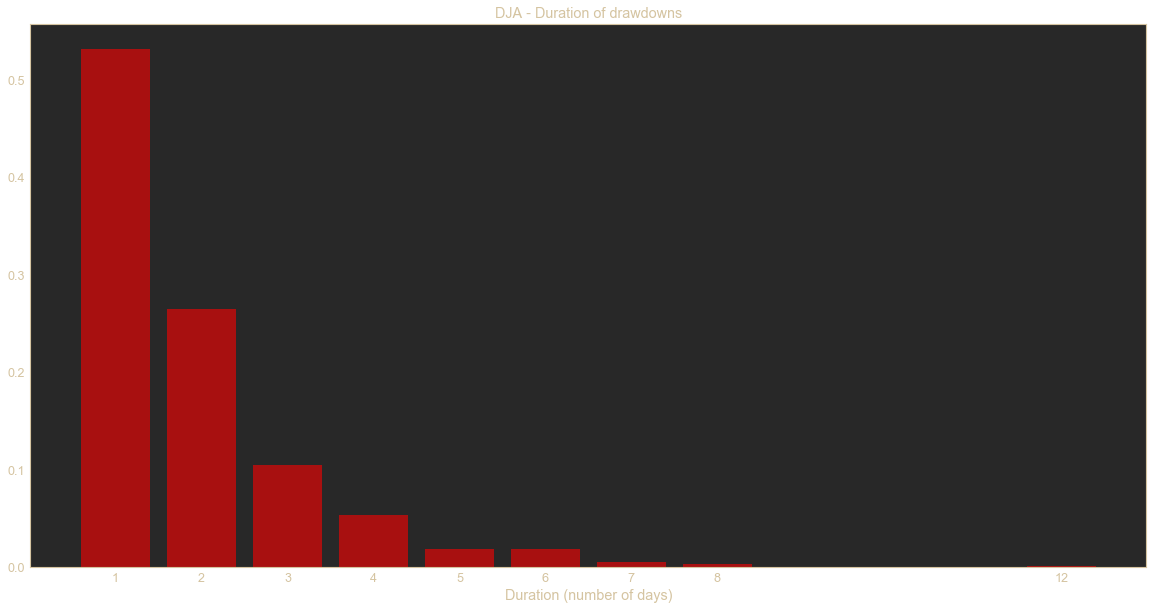

In [50]:
from collections import defaultdict
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

l_dict_dd = []

max_dd = max(abs(df_d['drawdown']))
m = round(max_dd+0.01,2)
bins = np.linspace(-m, m, 800)
d = {}
for i in range(1, len(bins)+1):
    d[i] = bins[i-1]
disc = np.digitize(x=df_d['drawdown'], bins=bins)
d1 = defaultdict(int)
for i in disc:
    d1[d[i]] += 1
l_dict_dd.append(d1)
plt.bar(x=df_d['duration'].value_counts().index, height=df_d['duration'].\
    value_counts()/df_d['duration'].shape[0], color='red', alpha=0.6)
plt.xticks(df_d['duration'].value_counts().index)
plt.title('DJA - Duration of drawdowns')
plt.xlabel('Duration (number of days)')
plt.grid()
plt.show()

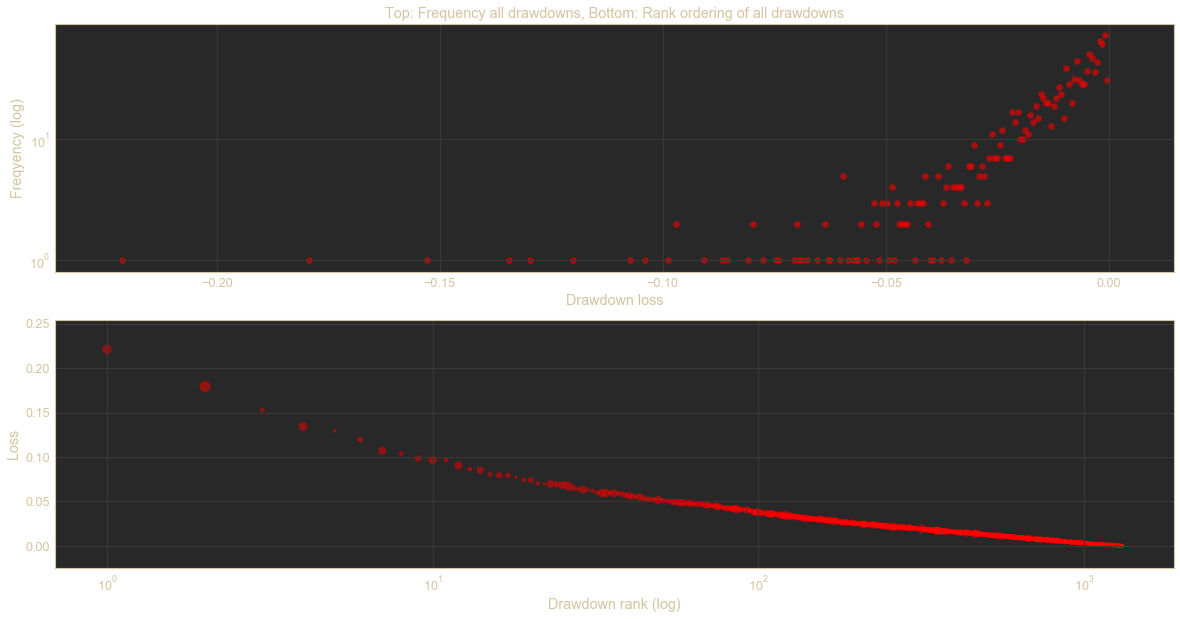

In [51]:
rcParams['figure.figsize'] = 16.5, 8.7
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 
for d1 in l_dict_dd:
    plt.subplot(gs[0])
    df_d_bins = pd.DataFrame(list(d1.items()))
    df_d_bins.columns = ['drawdown', 'n']
    plt.scatter(df_d_bins['drawdown'], df_d_bins['n'], s=40, color='red', alpha=0.6)
    plt.yscale('log')
    df_d_bins_reg = df_d_bins[df_d_bins['drawdown']>-0.08]
#     m, c = np.polyfit(df_d_bins_reg['drawdown'], np.log(df_d_bins_reg['n']), 1)
#     y_fit = np.exp(m*df_d_bins['drawdown'] + c)
    plt.ylim(bottom=10**-.1)
#     plt.plot(df_d_bins['drawdown'], y_fit, color='black', ls='dashed')
    plt.title('Top: Frequency all drawdowns, Bottom: Rank ordering of all drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Freqyency (log)')
    plt.grid(True)

plt.subplot(gs[1])
plt.scatter(df_d['rank'], abs(df_d['drawdown']), s=10*df_d['duration'], alpha=0.5,\
            color='red')
plt.xscale('log')
# plt.title('DJA - Rank ordering of all drawdowns')
plt.xlabel('Drawdown rank (log)')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
# plt.savefig('../experiments/resources/dja-ddstats-2000-2020', bbox_inches="tight")

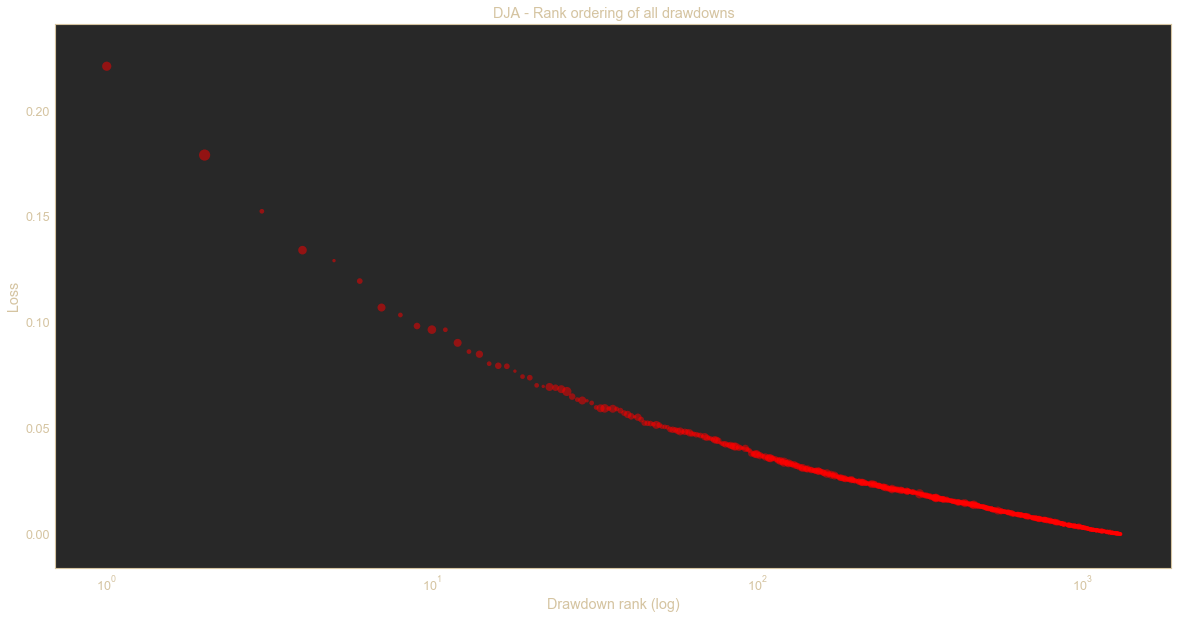

In [52]:
rcParams['figure.figsize'] = 20, 10
plt.scatter(df_d['rank'], abs(df_d['drawdown']), s=10*df_d['duration'], alpha=0.5,\
            color='red')
plt.xscale('log')
plt.title('DJA - Rank ordering of all drawdowns')
plt.xlabel('Drawdown rank (log)')
plt.ylabel('Loss')
plt.grid()
# plt.show()
# plt.savefig('../experiments/resources/dja-ddrank-2000-2020', bbox_inches="tight")

In [53]:
def get_dislocations(df_d, q):
    q = 1 - q
    crashes = df_d[df_d['drawdown'] < df_d.quantile(q)[0]]
    return crashes

dislocations = get_dislocations(df_d, q=0.95)
# dislocations.drop([pd.Timestamp('2000-10-04')], inplace=True)

In [54]:
dislocations

,drawdown,d_start,d_end,duration,rank
Date,,,,,
2008-09-30,-0.221136,2008-09-30,2008-10-10,8,1
2001-09-05,-0.179150,2001-09-05,2001-09-21,12,2
2020-03-10,-0.152591,2020-03-10,2020-03-12,2,3
2020-02-19,-0.134206,2020-02-19,2020-02-28,7,4
2020-03-13,-0.129265,2020-03-13,2020-03-16,1,5
2020-03-04,-0.119592,2020-03-04,2020-03-09,3,6
2015-08-17,-0.107080,2015-08-17,2015-08-25,6,7
2008-11-18,-0.103559,2008-11-18,2008-11-20,2,8
2002-07-17,-0.098349,2002-07-17,2002-07-23,4,9


Text(0, 0.5, 'Drawdown %')

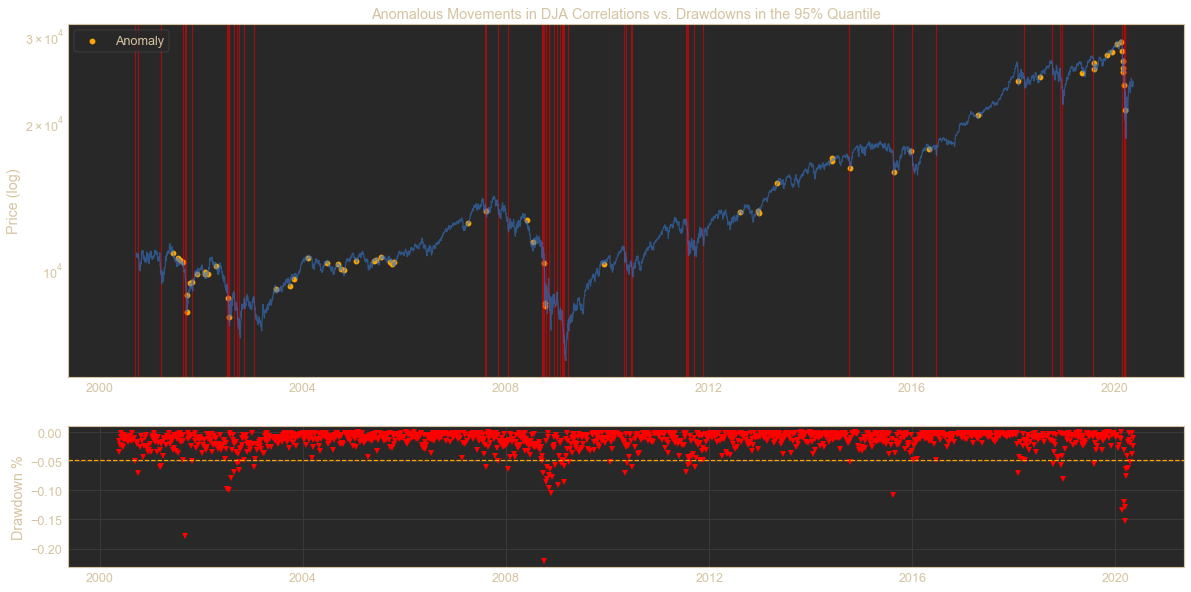

In [55]:
a = df_ec.loc[(df_ec['anomalies'] == -1)]
rcParams['figure.figsize'] = 20,10

gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
plt.subplot(gs[0])
plt.plot(df_ec.index, df_ec['DJA'], alpha=0.6)
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(dislocations['d_start'], dislocations['d_end'])]
plt.plot(df_d['drawdown'], color='red', marker='v', linestyle='')

plt.ylabel('Price (log)')
plt.title('Anomalous Movements in DJA Correlations vs. Drawdowns in the 95% Quantile')

plt.scatter(df_ec['DJA'][(df_ec['anomalies']==-1)].index, df_ec['DJA'][(df_ec['anomalies']==-1)], label='Anomaly', color='orange')
plt.legend()
plt.yscale('log')
plt.grid(False)

plt.subplot(gs[1])
plt.plot(df_d['drawdown'], color='red', marker='v', linestyle='')
plt.axhline(dislocations['drawdown'].tolist()[-1], color='orange', linestyle='dashed')
plt.ylabel('Drawdown %')

# plt.savefig('../experiments/resources/dja-anomalies-drawdowns-2000-2020-95', bbox_inches="tight")

In [56]:
print('number of anomalies:', len(a))

number of anomalies: 64


In [57]:
a['2020']

,global_eigencentrality,pct_change,anomalies,DJA
2020-01-14,0.187898,0.000803,-1,28939.669922
2020-02-11,0.187691,0.000991,-1,29276.339844
2020-02-24,0.187622,-0.001717,-1,27960.800781
2020-02-28,0.187751,0.001936,-1,25409.359375
2020-03-02,0.187924,0.000923,-1,26703.320313
2020-03-03,0.188072,0.000785,-1,25917.410156
2020-03-09,0.187794,-0.001044,-1,23851.019531
2020-03-12,0.188287,0.001563,-1,21200.619141


In [58]:
dislocations['2020']

,drawdown,d_start,d_end,duration,rank
Date,,,,,
2020-03-10,-0.152591,2020-03-10,2020-03-12,2,3
2020-02-19,-0.134206,2020-02-19,2020-02-28,7,4
2020-03-13,-0.129265,2020-03-13,2020-03-16,1,5
2020-03-04,-0.119592,2020-03-04,2020-03-09,3,6
2020-03-19,-0.074438,2020-03-19,2020-03-23,2,19
2020-03-17,-0.063024,2020-03-17,2020-03-18,1,30
2020-03-30,-0.061985,2020-03-30,2020-04-01,2,31
2020-04-17,-0.050474,2020-04-17,2020-04-21,2,53


In [59]:
print('number of dislocations:', len(dislocations))

number of dislocations: 66


In [60]:
print('approximately', np.ceil(len(a)/20), 'anomalies a year, or once a quarter' )

approximately 4.0 anomalies a year, or once a quarter


In [61]:
# def dist_stats(anomalies, dislocations, pred_range):
#     df_dist = pd.DataFrame(index=anomalies.index, columns=dislocations.index)
    
#     for i in anomalies.index:
#         for j in dislocations.index:
#             df_dist.at[i,j] = (i-j).days
    
#     hits = [df_dist[i].between(-pred_range, -1) for i in dislocations.index]
#     df_hits = pd.concat(hits, axis=1)
    
#     disloc_dates = dislocations.index.tolist()
#     tp_fn = [True in df_hits[i].tolist() for i in disloc_dates]

#     df_tpfn = pd.DataFrame(zip(disloc_dates, tp_fn))
#     df_tpfn.columns = ['drawdown', 'predicted']
    
#     tp = df_tpfn[df_tpfn['predicted'] == True]
#     return dislocations.index[tp['drawdown']]

# dist_stats(anomalies, get_dislocations(df_d, 0.95), 231)

In [62]:
def recall_score(anomalies, dislocations, pred_range, verbose=False):
    df_dist = pd.DataFrame(index=anomalies.index, columns=dislocations.index)
    
    for i in anomalies.index:
        for j in dislocations.index:
            df_dist.at[i,j] = (i-j).days
    
    hits = [df_dist[i].between(-pred_range, -1) for i in dislocations.index]
    df_hits = pd.concat(hits, axis=1)
    
    disloc_dates = dislocations.index.tolist()
    tp_fn = [True in df_hits[i].tolist() for i in disloc_dates]

    df_tpfn = pd.DataFrame(zip(disloc_dates, tp_fn))
    df_tpfn.columns = ['drawdown', 'predicted']
    
    tp = len(df_tpfn[df_tpfn['predicted'] == True])
    fn = len(df_tpfn[df_tpfn['predicted'] == False])
    
    recall = tp / (tp + fn)
    if not verbose:
        return recall, tp, fn
    if verbose:
        return print('Recall:', recall, '\n\n', df_tpfn)
            
recall_score(a, get_dislocations(df_d, 0.995), 231)

(0.8571428571428571, 6, 1)

In [63]:
def precision_score(anomalies, dislocations, pred_range, verbose=False):
    df_dist = pd.DataFrame(index=anomalies.index, columns=dislocations.index)
    
    for i in anomalies.index:
        for j in dislocations.index:
            df_dist.at[i,j] = (i-j).days
    
    hits = [df_dist[i].between(-pred_range, -1) for i in dislocations.index]
    df_hits = pd.concat(hits, axis=1)
    
    anom_dates = anomalies.index.tolist()
    disloc_dates = dislocations.index.tolist()
    
    fp = [True in df_hits.loc[i].tolist() for i in anom_dates]
    tp = [True in df_hits[i].tolist() for i in disloc_dates]

    df_fp = pd.DataFrame(zip(anom_dates, fp))
    df_fp.columns = ['anomalies', 'ground']
    
    df_tpfn = pd.DataFrame(zip(disloc_dates, tp))
    df_tpfn.columns = ['drawdown', 'predicted']

    fp = len(df_fp[df_fp['ground'] == False])
    tp = len(df_tpfn[df_tpfn['predicted'] == True])
    
    precision = tp / (tp + fp)
    if not verbose:
        return precision, tp, fp
    if verbose:
        return print('Precision:', precision, '\n\n', df_fp)
    
precision_score(a, get_dislocations(df_d, 0.995), 231)

(0.11764705882352941, 6, 45)

In [64]:
(recall_score(a, get_dislocations(df_d, 0.995), 231)[0] + precision_score(a, get_dislocations(df_d, 0.995), 231)[0])/2

0.48739495798319327

In [65]:
def f_score(precision, recall, beta):
    f = (1 + beta**2) * ((precision*recall)/( (beta**2 * precision) + recall ))
    return f

f_score(precision_score(a, dislocations, 231)[0], recall_score(a, dislocations, 231)[0], beta=2)

0.7964601769911505

In [66]:
tp = 79
fn = 26
fp = 11
tn = len(df_ec) - (tp + fn + fp)

In [67]:
def matthews_corrcoeff(tp, fn, fp, tn):
    n = tp*tn - fp*fn
    d = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return n/d

matthews_corrcoeff(tp,fn,fp,tn)

0.8089538436345673

In [68]:
def balanced_accuracy(precision, recall):
    return 0.5*(precision + recall)

balanced_accuracy(precision_score(a, dislocations, 87)[0], recall_score(a, dislocations, 87)[0])

0.5151515151515151

In [69]:
df_eval = pd.DataFrame({
    'Recall': [
        recall_score(a, get_dislocations(df_d, x), 231, verbose=False)[0] 
        for x in np.arange(0.90, 1, 0.005)
    ],
    'F-beta score (beta=2)': [
        f_score(precision_score(a, get_dislocations(df_d, x), 231)[0], recall_score(a, get_dislocations(df_d, x), 231)[0], beta=2)
        for x in np.arange(0.90, 1, 0.005) 
    ],
    'Balanced Accuracy': [
        balanced_accuracy(recall_score(a, get_dislocations(df_d, x), 231, verbose=False)[0], precision_score(a, get_dislocations(df_d, x), 231, verbose=False)[0])
        for x in np.arange(0.90, 1, 0.005)
    ],
    'Precision': [
        precision_score(a, get_dislocations(df_d, x), 231, verbose=False)[0]
        for x in np.arange(0.90, 1, 0.005)
    ],
    'Quantile of Drawdowns': [str(round(x*100,2)) + '%' for x in np.arange(0.90, 1, 0.005).tolist()]
})

In [70]:
df_eval = df_eval.melt(id_vars='Quantile of Drawdowns')
df_eval.columns = ['Quantile of Drawdowns', 'Statistic', 'Score']

In [71]:
df_eval[df_eval['Statistic'] == 'Balanced Accuracy']

,Quantile of Drawdowns,Statistic,Score
40,90.0%,Balanced Accuracy,0.808155
41,90.5%,Balanced Accuracy,0.801000
42,91.0%,Balanced Accuracy,0.804644
43,91.5%,Balanced Accuracy,0.806932
44,92.0%,Balanced Accuracy,0.815079
45,92.5%,Balanced Accuracy,0.806061
46,93.0%,Balanced Accuracy,0.809909
47,93.5%,Balanced Accuracy,0.803115
48,94.0%,Balanced Accuracy,0.787623
49,94.5%,Balanced Accuracy,0.772860


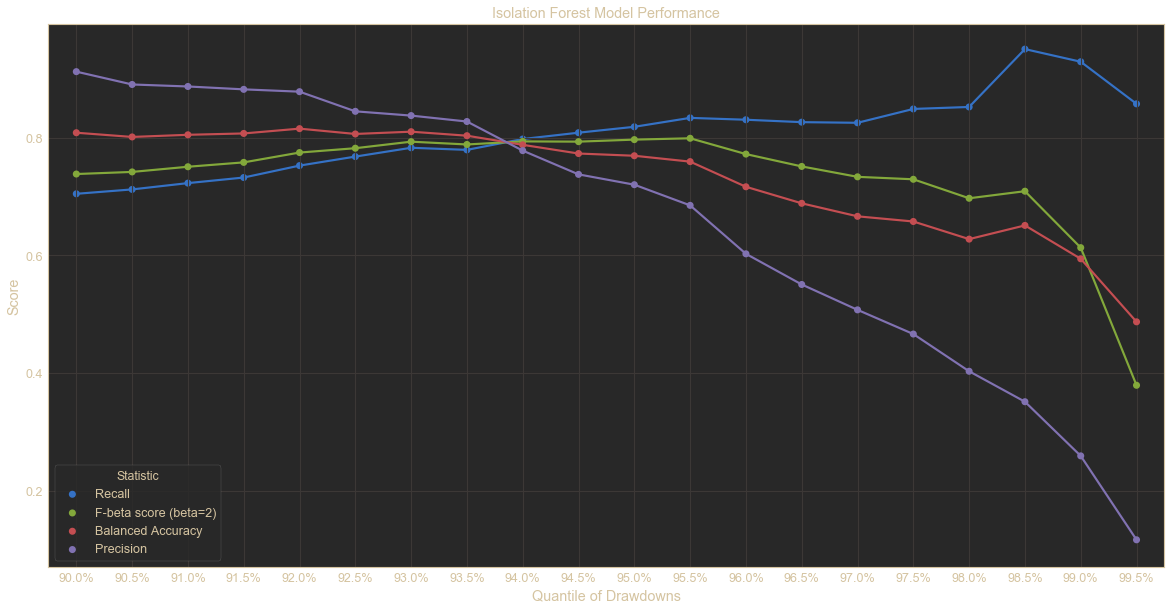

In [72]:
sns.pointplot(y='Score', x='Quantile of Drawdowns', hue='Statistic', data=df_eval)
# g.fig.set_figwidth(20)
# g.fig.set_figheight(10)
plt.title('Isolation Forest Model Performance')
plt.xlabel('Quantile of Drawdowns')
plt.grid(True)
# plt.savefig('../experiments/resources/dcor-eigencentrality-iforest-perf-2000-2020', bbox_inches="tight")